In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import numpy as np
import cv2

import torch
from torch import nn
from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import Cityscapes
from torchvision import transforms
import torchvision as tv
import torch.nn.functional as F
from torch import Tensor
from torchmetrics import Dice
from torchmetrics.classification import MulticlassJaccardIndex

In [2]:
label_map = {
    0 : ['unlabeled', 19, 'void'], 
    1 : ['ego vehicle', 19, 'void'],
    2 : ['rectification border', 19, 'void'],
    3 : ['out of roi', 19, 'void'],
    4 : ['static', 19, 'void'],
    5 : ['dynamic', 19, 'void'],
    6 : ['ground', 19, 'void'],
    7 : ['road', 0, 'flat'],
    8 : ['sidewalk', 1, 'flat'],
    9 : ['parking', 19, 'flat'],
    10 : ['rail track', 19, 'flat'],
    11 : ['building', 2, 'construction'],
    12 : ['wall', 3, 'construction'],
    13 : ['fence', 4, 'construction'],
    14 : ['guard rail', 19, 'construction'],
    15 : ['bridge', 19, 'construction'],
    16 : ['tunnel', 19, 'construction'],
    17 : ['pole', 5, 'object'],
    18 : ['polegroup', 19, 'object'],
    19 : ['traffic light', 6, 'object'],
    20 : ['traffic sign', 7, 'object'],
    21 : ['vegetation', 8, 'nature'],
    22 : ['terrain', 9, 'nature'],
    23 : ['sky', 10, 'sky'],
    24 : ['person', 11, 'human'],
    25 : ['rider', 12, 'human'],
    26 : ['car', 13, 'vehicle'],
    27 : ['truck', 14, 'vehicle'],
    28 : ['bus', 15, 'vehicle'],
    29 : ['caravan', 19, 'vehicle'],
    30 : ['trailer', 19, 'vehicle'],
    31 : ['train', 16, 'vehicle'],
    32 : ['motorcycle', 17, 'vehicle'],
    33 : ['bicycle', 18, 'vehicle'],
    34 : ['license plate', -1, 'vehicle']
}

In [3]:
class MakeClass(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        encx = torch.zeros(x.shape, dtype=torch.long)
        for label in label_map:
            encx[x == label] = label_map[label][1]
        onehot = F.one_hot(encx.squeeze(1), 20).permute(0, 3, 1, 2)[0].float()
        return onehot[:-1]

In [4]:
transform = transforms.Compose(
    [
        transforms.Resize((256, 512)),
        transforms.ToTensor(),
    ]
)

target_transform = transforms.Compose(
    [
        transforms.Resize((256, 512)),
        transforms.PILToTensor(), 
        MakeClass()
    ]
)

train_ds = Cityscapes(
    root = "/media/mountHDD2/cityscapes", split = "train", mode = "fine", target_type = "semantic", 
    transform = transform, 
    target_transform = target_transform
)

valid_ds = Cityscapes(
    root = "/media/mountHDD2/cityscapes", split = "val", mode = "fine", target_type = "semantic", 
    transform = transform, 
    target_transform = target_transform    
)

test_ds = Cityscapes(
    root = "/media/mountHDD2/cityscapes", split = "test", mode = "fine", target_type = "semantic", 
    transform = transform, 
    target_transform = target_transform
)

train_dl = DataLoader(train_ds, batch_size=32, shuffle=True, pin_memory = True, num_workers=24)
valid_dl = DataLoader(valid_ds, batch_size=32, shuffle=True, pin_memory = True, num_workers=24)
test_dl = DataLoader(test_ds, batch_size=32, shuffle=True, pin_memory = True, num_workers=24)

print("#Training Samples: {}".format(len(train_ds)))
print("#Validation Samples: {}".format(len(valid_ds)))
print("#Testing Samples: {}".format(len(test_ds)))
print("#Training Batch: {}".format(len(train_dl)))
print("#Validation Batch: {}".format(len(valid_dl)))
print("#Testing Batch: {}".format(len(test_dl)))

#Training Samples: 2975
#Validation Samples: 500
#Testing Samples: 1525
#Training Batch: 93
#Validation Batch: 16
#Testing Batch: 48


data shape: torch.Size([3, 256, 512])
mask shape: torch.Size([19, 256, 512])
Number classes: 19
Classes: tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13])


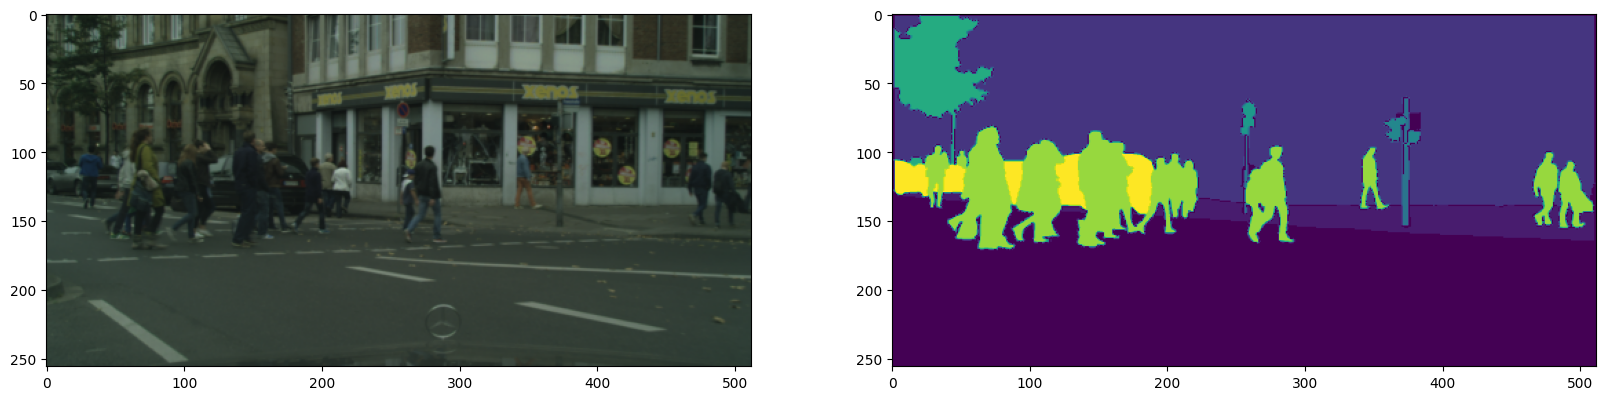

In [5]:
sample_data, sample_mask = train_ds[19]

print(f"data shape: {sample_data.shape}")
print(f"mask shape: {sample_mask.shape}")
num_class = sample_mask.shape[0]
print(f"Number classes: {num_class}")
print(f"Classes: {torch.unique(torch.argmax(sample_mask, dim = 0))}")

f, axarr = plt.subplots(1, 2, figsize=(20, 15))
axarr[0].imshow(sample_data.permute(1, -1, 0).numpy())
axarr[1].imshow(torch.argmax(sample_mask, dim = 0).unsqueeze(0).permute(1, -1, 0).numpy())

In [6]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

In [7]:
class Down(nn.Module):

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

In [8]:
class Up(nn.Module):    

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

In [9]:
class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

In [10]:
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=False):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = (DoubleConv(n_channels, 16))
        self.down1 = (Down(16, 32)) #64, 128
        self.down2 = (Down(32, 64)) #128, 256
        self.down3 = (Down(64, 128)) #256, 512
        factor = 2 if bilinear else 1
        self.down4 = (Down(128, 256 // factor)) #512, 1024
        self.up1 = (Up(256, 128 // factor, bilinear)) #1024, 512
        self.up2 = (Up(128, 64 // factor, bilinear)) #512, 256
        self.up3 = (Up(64, 32 // factor, bilinear)) #256, 128
        self.up4 = (Up(32, 16, bilinear)) #128, 64
        self.outc = (OutConv(16, n_classes)) #64

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

In [11]:
def dice_coeff(input: Tensor, target: Tensor, reduce_batch_first: bool = False, epsilon: float = 1e-6):
    # Average of Dice coefficient for all batches, or for a single mask
    assert input.size() == target.size()
    assert input.dim() == 3 or not reduce_batch_first

    sum_dim = (-1, -2) if input.dim() == 2 or not reduce_batch_first else (-1, -2, -3)

    inter = 2 * (input * target).sum(dim=sum_dim)
    sets_sum = input.sum(dim=sum_dim) + target.sum(dim=sum_dim)
    sets_sum = torch.where(sets_sum == 0, inter, sets_sum)

    dice = (inter + epsilon) / (sets_sum + epsilon)
    return dice.mean()


def multiclass_dice_coeff(input: Tensor, target: Tensor, reduce_batch_first: bool = False, epsilon: float = 1e-6):
    # Average of Dice coefficient for all classes
    return dice_coeff(input.flatten(0, 1), target.flatten(0, 1), reduce_batch_first, epsilon)


def dice_loss(input: Tensor, target: Tensor, multiclass: bool = False):
    # Dice loss (objective to minimize) between 0 and 1
    fn = multiclass_dice_coeff if multiclass else dice_coeff
    return 1 - fn(input, target, reduce_batch_first=True)

In [12]:
from typing import *
class FocalLoss(nn.Module):
    def __init__(self, gamma: int, weights: list[float] = None, reduction = 'mean'):
        super().__init__()

        if weights is not None:
            self.weights = torch.from_numpy(np.array(weights)).view(-1, len(weights), 1, 1)
        else:
            self.weights = None 

        self.gamma = gamma
        self.reduc = reduction

    def forward(self, preds: torch.Tensor, targets: torch.Tensor):

        if self.weights is None:
            self.weights = torch.ones(1, targets.shape[1], 1, 1).to(targets.device)
        else:
            self.weights = self.weights.to(targets.device)
        
        coeff = torch.pow(1 - preds, self.gamma)

        loss = -nn.LogSoftmax(1)(preds)*targets*self.weights

        focal_loss = loss * coeff

        if self.reduc == 'none':
            return focal_loss
        elif self.reduc == 'class_sum':
            return focal_loss.sum(1)
        elif self.reduc == 'sum':
            return focal_loss.sum()
        elif self.reduc == 'mean':
            return focal_loss.mean()

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu", index = 0)

model = UNet(3, num_class, False).to(device)

optimizer = Adam(params = model.parameters(), lr = 0.001)

epochs = 100

scheduler = CosineAnnealingLR(optimizer, epochs * len(train_dl))

train_loss_fn = FocalLoss(gamma = 2)
valid_loss_fn = nn.CrossEntropyLoss()

metric_dice = Dice().to(device)
metric_iou = MulticlassJaccardIndex(num_classes=num_class).to(device)

In [14]:
old_loss = 1e26
best_dct = None
last_dst = None
for epoch in range(epochs):
    model.train()
    tr_total_loss = 0
    tr_total_dice = 0
    tr_total_iou = 0
    for train_img, train_mask in tqdm(train_dl):
        train_img = train_img.to(device)
        train_mask = train_mask.to(device)

        train_gen_mask = model(train_img)        
        train_rec_loss = train_loss_fn(train_gen_mask, train_mask)
        train_dice_loss = dice_loss(
            F.softmax(train_gen_mask, dim=1).float(),
            train_mask.float(),
            multiclass=True
        )
        train_loss = train_rec_loss + train_dice_loss

        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        scheduler.step()

        train_dice = metric_dice(train_gen_mask, train_mask.to(dtype=torch.uint8))
        train_iou = metric_iou(train_gen_mask.argmax(1), train_mask.argmax(1).to(dtype=torch.uint8))
        
        tr_total_loss += train_loss.cpu().item()
        tr_total_dice += train_dice
        tr_total_iou += train_iou

    model.eval()
    with torch.no_grad():
        va_total_loss = 0
        va_total_dice = 0
        va_total_iou = 0
        for valid_img, valid_mask in tqdm(valid_dl):
            valid_img = valid_img.to(device)
            valid_mask = valid_mask.to(device)
            
            valid_gen_mask = model(valid_img)
            valid_rec_loss = valid_loss_fn(valid_gen_mask, valid_mask)
            valid_dice_loss = dice_loss(
                F.softmax(valid_gen_mask, dim=1).float(),
                valid_mask.float(),
                multiclass=True
            )
            valid_loss = valid_rec_loss + valid_dice_loss
            valid_dice = metric_dice(valid_gen_mask, valid_mask.to(dtype=torch.uint8))
            valid_iou = metric_iou(valid_gen_mask.argmax(1), valid_mask.argmax(1).to(dtype=torch.uint8))
            
            va_total_loss += valid_loss.cpu().item()
            va_total_dice += valid_dice
            va_total_iou += valid_iou
            
    mean_train_loss = tr_total_loss/len(train_dl)
    mean_train_dice = tr_total_dice/len(train_dl)
    mean_train_iou = tr_total_iou/len(train_dl)

    mean_valid_loss = va_total_loss/len(valid_dl)
    mean_valid_dice = va_total_dice/len(valid_dl)
    mean_valid_iou = va_total_iou/len(valid_dl)

    if mean_valid_loss <= old_loss:
        old_loss = mean_valid_loss
        best_dct = model.state_dict()
    
    last_dct = model.state_dict()

    print(f"Epoch: {epoch} - TrainLoss: {mean_train_loss} - ValidLoss: {mean_valid_loss}")
    print(f"Epoch: {epoch} - TrainDice: {mean_train_dice} - TrainIOU: {mean_train_iou}")
    print(f"Epoch: {epoch} - ValidDice: {mean_valid_dice} - ValidIOU: {mean_valid_iou}")
model.load_state_dict(best_dct)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.29it/s]


Epoch: 0 - TrainLoss: 0.9014180988393804 - ValidLoss: 1.7072143256664276
Epoch: 0 - TrainDice: 0.3804784119129181 - TrainIOU: 0.0761946514248848
Epoch: 0 - ValidDice: 0.4991171956062317 - ValidIOU: 0.11665288358926773


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.29it/s]


Epoch: 1 - TrainLoss: 0.603345868087584 - ValidLoss: 1.2979891151189804
Epoch: 1 - TrainDice: 0.5744169354438782 - TrainIOU: 0.14615018665790558
Epoch: 1 - ValidDice: 0.6174103021621704 - ValidIOU: 0.13475097715854645


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.34it/s]


Epoch: 2 - TrainLoss: 0.42766593669050484 - ValidLoss: 1.130008727312088
Epoch: 2 - TrainDice: 0.6936957240104675 - TrainIOU: 0.16064783930778503
Epoch: 2 - ValidDice: 0.6696301698684692 - ValidIOU: 0.1623496264219284


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.29it/s]


Epoch: 3 - TrainLoss: 0.3577182055801474 - ValidLoss: 1.0975412875413895
Epoch: 3 - TrainDice: 0.6792830228805542 - TrainIOU: 0.19073840975761414
Epoch: 3 - ValidDice: 0.5993630886077881 - ValidIOU: 0.17560435831546783


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.30it/s]


Epoch: 4 - TrainLoss: 0.32401857260734807 - ValidLoss: 0.9520387798547745
Epoch: 4 - TrainDice: 0.612201988697052 - TrainIOU: 0.2019432634115219
Epoch: 4 - ValidDice: 0.5094374418258667 - ValidIOU: 0.1972895860671997


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.30it/s]


Epoch: 5 - TrainLoss: 0.29842368505334343 - ValidLoss: 0.9669871293008327
Epoch: 5 - TrainDice: 0.4510483741760254 - TrainIOU: 0.20536701381206512
Epoch: 5 - ValidDice: 0.3959793448448181 - ValidIOU: 0.19615685939788818


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.29it/s]


Epoch: 6 - TrainLoss: 0.2732766014273449 - ValidLoss: 1.0221123583614826
Epoch: 6 - TrainDice: 0.37629926204681396 - TrainIOU: 0.2073376178741455
Epoch: 6 - ValidDice: 0.3506021201610565 - ValidIOU: 0.1907953917980194


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.26it/s]


Epoch: 7 - TrainLoss: 0.24014427264531454 - ValidLoss: 0.9262045808136463
Epoch: 7 - TrainDice: 0.31102097034454346 - TrainIOU: 0.21024180948734283
Epoch: 7 - ValidDice: 0.2761823534965515 - ValidIOU: 0.20125363767147064


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.31it/s]


Epoch: 8 - TrainLoss: 0.22507925636024886 - ValidLoss: 0.9404831007122993
Epoch: 8 - TrainDice: 0.2688230574131012 - TrainIOU: 0.21167859435081482
Epoch: 8 - ValidDice: 0.2520293891429901 - ValidIOU: 0.20285335183143616


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.22it/s]


Epoch: 9 - TrainLoss: 0.2173841166239913 - ValidLoss: 1.0299221463501453
Epoch: 9 - TrainDice: 0.2460242211818695 - TrainIOU: 0.21206781268119812
Epoch: 9 - ValidDice: 0.23551110923290253 - ValidIOU: 0.202914297580719


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.21it/s]


Epoch: 10 - TrainLoss: 0.2104410110942779 - ValidLoss: 0.9981688484549522
Epoch: 10 - TrainDice: 0.22346004843711853 - TrainIOU: 0.21184076368808746
Epoch: 10 - ValidDice: 0.21532757580280304 - ValidIOU: 0.20454485714435577


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.32it/s]


Epoch: 11 - TrainLoss: 0.20687715276595084 - ValidLoss: 1.189914956688881
Epoch: 11 - TrainDice: 0.2041844129562378 - TrainIOU: 0.2116578221321106
Epoch: 11 - ValidDice: 0.1829213798046112 - ValidIOU: 0.197000652551651


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.27it/s]


Epoch: 12 - TrainLoss: 0.2026895739698923 - ValidLoss: 1.1340173818171024
Epoch: 12 - TrainDice: 0.19137738645076752 - TrainIOU: 0.21250638365745544
Epoch: 12 - ValidDice: 0.1879337877035141 - ValidIOU: 0.2029968649148941


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.38it/s]


Epoch: 13 - TrainLoss: 0.19892578580046213 - ValidLoss: 1.112885307520628
Epoch: 13 - TrainDice: 0.18516883254051208 - TrainIOU: 0.21273671090602875
Epoch: 13 - ValidDice: 0.18173086643218994 - ValidIOU: 0.19873875379562378


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.21it/s]


Epoch: 14 - TrainLoss: 0.19514746162840116 - ValidLoss: 1.1477584391832352
Epoch: 14 - TrainDice: 0.1800829917192459 - TrainIOU: 0.21444250643253326
Epoch: 14 - ValidDice: 0.17267194390296936 - ValidIOU: 0.20171044766902924


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.28it/s]


Epoch: 15 - TrainLoss: 0.1928413495902092 - ValidLoss: 1.2143493071198463
Epoch: 15 - TrainDice: 0.17371918261051178 - TrainIOU: 0.21507416665554047
Epoch: 15 - ValidDice: 0.16884054243564606 - ValidIOU: 0.20156648755073547


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.35it/s]


Epoch: 16 - TrainLoss: 0.19184846150618728 - ValidLoss: 1.1841595768928528
Epoch: 16 - TrainDice: 0.16839325428009033 - TrainIOU: 0.2173098921775818
Epoch: 16 - ValidDice: 0.1658756285905838 - ValidIOU: 0.20561404526233673


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.23it/s]


Epoch: 17 - TrainLoss: 0.18899498735704728 - ValidLoss: 1.1760471761226654
Epoch: 17 - TrainDice: 0.16421464085578918 - TrainIOU: 0.21928854286670685
Epoch: 17 - ValidDice: 0.15921956300735474 - ValidIOU: 0.2128639817237854


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.24it/s]


Epoch: 18 - TrainLoss: 0.18823995961937853 - ValidLoss: 1.2279078289866447
Epoch: 18 - TrainDice: 0.16096603870391846 - TrainIOU: 0.21982812881469727
Epoch: 18 - ValidDice: 0.16341549158096313 - ValidIOU: 0.20252308249473572


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.24it/s]


Epoch: 19 - TrainLoss: 0.18693014899248717 - ValidLoss: 1.3399836421012878
Epoch: 19 - TrainDice: 0.1587105542421341 - TrainIOU: 0.222664475440979
Epoch: 19 - ValidDice: 0.1571488082408905 - ValidIOU: 0.2117227464914322


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.26it/s]


Epoch: 20 - TrainLoss: 0.18502599609795436 - ValidLoss: 1.2188433110713959
Epoch: 20 - TrainDice: 0.15665607154369354 - TrainIOU: 0.22483167052268982
Epoch: 20 - ValidDice: 0.15450437366962433 - ValidIOU: 0.20688149333000183


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.33it/s]


Epoch: 21 - TrainLoss: 0.18387180374514672 - ValidLoss: 1.3011578992009163
Epoch: 21 - TrainDice: 0.15586905181407928 - TrainIOU: 0.22498777508735657
Epoch: 21 - ValidDice: 0.1541621834039688 - ValidIOU: 0.21303783357143402


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.27it/s]


Epoch: 22 - TrainLoss: 0.18445438290795974 - ValidLoss: 1.2409245893359184
Epoch: 22 - TrainDice: 0.15477944910526276 - TrainIOU: 0.22458572685718536
Epoch: 22 - ValidDice: 0.15450236201286316 - ValidIOU: 0.21117903292179108


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.24it/s]


Epoch: 23 - TrainLoss: 0.18240241738416815 - ValidLoss: 1.330645129084587
Epoch: 23 - TrainDice: 0.152952641248703 - TrainIOU: 0.22576116025447845
Epoch: 23 - ValidDice: 0.1498224139213562 - ValidIOU: 0.21419818699359894


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.25it/s]


Epoch: 24 - TrainLoss: 0.18145415443246082 - ValidLoss: 1.2226115316152573
Epoch: 24 - TrainDice: 0.15152688324451447 - TrainIOU: 0.22730503976345062
Epoch: 24 - ValidDice: 0.149318128824234 - ValidIOU: 0.21783903241157532


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.27it/s]


Epoch: 25 - TrainLoss: 0.1802261644794095 - ValidLoss: 1.2442775592207909
Epoch: 25 - TrainDice: 0.1500692367553711 - TrainIOU: 0.23133200407028198
Epoch: 25 - ValidDice: 0.14756108820438385 - ValidIOU: 0.21948087215423584


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.36it/s]


Epoch: 26 - TrainLoss: 0.17792138232979723 - ValidLoss: 1.237396128475666
Epoch: 26 - TrainDice: 0.14842821657657623 - TrainIOU: 0.24047090113162994
Epoch: 26 - ValidDice: 0.14876803755760193 - ValidIOU: 0.21740514039993286


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.25it/s]


Epoch: 27 - TrainLoss: 0.1767408953559014 - ValidLoss: 1.2722043991088867
Epoch: 27 - TrainDice: 0.14763092994689941 - TrainIOU: 0.24321582913398743
Epoch: 27 - ValidDice: 0.14468824863433838 - ValidIOU: 0.22923240065574646


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.29it/s]


Epoch: 28 - TrainLoss: 0.17657035204672045 - ValidLoss: 1.3474200665950775
Epoch: 28 - TrainDice: 0.14511257410049438 - TrainIOU: 0.24188074469566345
Epoch: 28 - ValidDice: 0.14535556733608246 - ValidIOU: 0.2179463505744934


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.25it/s]


Epoch: 29 - TrainLoss: 0.17365716557989838 - ValidLoss: 1.334472469985485
Epoch: 29 - TrainDice: 0.1436951905488968 - TrainIOU: 0.24376963078975677
Epoch: 29 - ValidDice: 0.14334969222545624 - ValidIOU: 0.22580096125602722


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.28it/s]


Epoch: 30 - TrainLoss: 0.1719274022566375 - ValidLoss: 1.2165472134947777
Epoch: 30 - TrainDice: 0.14326073229312897 - TrainIOU: 0.2458501011133194
Epoch: 30 - ValidDice: 0.14299726486206055 - ValidIOU: 0.22334201633930206


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.26it/s]


Epoch: 31 - TrainLoss: 0.17059128963819115 - ValidLoss: 1.230361957103014
Epoch: 31 - TrainDice: 0.14270755648612976 - TrainIOU: 0.2465667575597763
Epoch: 31 - ValidDice: 0.1423029601573944 - ValidIOU: 0.22390101850032806


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.30it/s]


Epoch: 32 - TrainLoss: 0.1700453918467286 - ValidLoss: 1.2058926597237587
Epoch: 32 - TrainDice: 0.14259447157382965 - TrainIOU: 0.24697139859199524
Epoch: 32 - ValidDice: 0.1408601850271225 - ValidIOU: 0.2262340486049652


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.17it/s]


Epoch: 33 - TrainLoss: 0.16927227762437635 - ValidLoss: 1.2471505776047707
Epoch: 33 - TrainDice: 0.1422584503889084 - TrainIOU: 0.24811209738254547
Epoch: 33 - ValidDice: 0.1412084400653839 - ValidIOU: 0.22927814722061157


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.25it/s]


Epoch: 34 - TrainLoss: 0.16877274103062126 - ValidLoss: 1.2202972620725632
Epoch: 34 - TrainDice: 0.14224903285503387 - TrainIOU: 0.24858306348323822
Epoch: 34 - ValidDice: 0.14149345457553864 - ValidIOU: 0.22789576649665833


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.24it/s]


Epoch: 35 - TrainLoss: 0.16921017310952627 - ValidLoss: 1.2851016744971275
Epoch: 35 - TrainDice: 0.14173302054405212 - TrainIOU: 0.24844549596309662
Epoch: 35 - ValidDice: 0.14255376160144806 - ValidIOU: 0.23333311080932617


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.36it/s]


Epoch: 36 - TrainLoss: 0.16817086646633764 - ValidLoss: 1.2846588641405106
Epoch: 36 - TrainDice: 0.14167316257953644 - TrainIOU: 0.24977515637874603
Epoch: 36 - ValidDice: 0.14181163907051086 - ValidIOU: 0.234030619263649


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.31it/s]


Epoch: 37 - TrainLoss: 0.1685440606007012 - ValidLoss: 1.3287503644824028
Epoch: 37 - TrainDice: 0.14109288156032562 - TrainIOU: 0.24923042953014374
Epoch: 37 - ValidDice: 0.14162686467170715 - ValidIOU: 0.23319058120250702


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.27it/s]


Epoch: 38 - TrainLoss: 0.16721554324832014 - ValidLoss: 1.295059747993946
Epoch: 38 - TrainDice: 0.14074277877807617 - TrainIOU: 0.25059249997138977
Epoch: 38 - ValidDice: 0.13931269943714142 - ValidIOU: 0.2291976660490036


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.26it/s]


Epoch: 39 - TrainLoss: 0.16686723549519816 - ValidLoss: 1.3530791774392128
Epoch: 39 - TrainDice: 0.13984662294387817 - TrainIOU: 0.2500760555267334
Epoch: 39 - ValidDice: 0.13930270075798035 - ValidIOU: 0.22615362703800201


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.19it/s]


Epoch: 40 - TrainLoss: 0.16540886029120414 - ValidLoss: 1.258411556482315
Epoch: 40 - TrainDice: 0.13951000571250916 - TrainIOU: 0.25003865361213684
Epoch: 40 - ValidDice: 0.1387975513935089 - ValidIOU: 0.2289927750825882


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.31it/s]


Epoch: 41 - TrainLoss: 0.1648166528953019 - ValidLoss: 1.3365796580910683
Epoch: 41 - TrainDice: 0.13950319588184357 - TrainIOU: 0.2509606182575226
Epoch: 41 - ValidDice: 0.14038245379924774 - ValidIOU: 0.23332150280475616


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.24it/s]


Epoch: 42 - TrainLoss: 0.16406097671677988 - ValidLoss: 1.340843677520752
Epoch: 42 - TrainDice: 0.13921909034252167 - TrainIOU: 0.2500033676624298
Epoch: 42 - ValidDice: 0.1380714327096939 - ValidIOU: 0.23106266558170319


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.29it/s]


Epoch: 43 - TrainLoss: 0.16331049671737097 - ValidLoss: 1.2812322154641151
Epoch: 43 - TrainDice: 0.13873954117298126 - TrainIOU: 0.2508627474308014
Epoch: 43 - ValidDice: 0.13834893703460693 - ValidIOU: 0.22849494218826294


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.25it/s]


Epoch: 44 - TrainLoss: 0.16294751468525137 - ValidLoss: 1.2695069909095764
Epoch: 44 - TrainDice: 0.13878820836544037 - TrainIOU: 0.25085705518722534
Epoch: 44 - ValidDice: 0.13823941349983215 - ValidIOU: 0.2274545282125473


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.24it/s]


Epoch: 45 - TrainLoss: 0.16256803963133085 - ValidLoss: 1.2761387526988983
Epoch: 45 - TrainDice: 0.13834741711616516 - TrainIOU: 0.25023919343948364
Epoch: 45 - ValidDice: 0.13783852756023407 - ValidIOU: 0.2247103452682495


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.23it/s]


Epoch: 46 - TrainLoss: 0.16256454506868956 - ValidLoss: 1.2847909778356552
Epoch: 46 - TrainDice: 0.13852857053279877 - TrainIOU: 0.2514580488204956
Epoch: 46 - ValidDice: 0.13721078634262085 - ValidIOU: 0.22924864292144775


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.27it/s]


Epoch: 47 - TrainLoss: 0.16221721133878153 - ValidLoss: 1.338762603700161
Epoch: 47 - TrainDice: 0.13837379217147827 - TrainIOU: 0.2517123520374298
Epoch: 47 - ValidDice: 0.13768965005874634 - ValidIOU: 0.2305344194173813


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.28it/s]


Epoch: 48 - TrainLoss: 0.16138004135060055 - ValidLoss: 1.2655597850680351
Epoch: 48 - TrainDice: 0.13811130821704865 - TrainIOU: 0.2550235688686371
Epoch: 48 - ValidDice: 0.1366925835609436 - ValidIOU: 0.232042595744133


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.30it/s]


Epoch: 49 - TrainLoss: 0.16072656534692292 - ValidLoss: 1.3136465474963188
Epoch: 49 - TrainDice: 0.13833551108837128 - TrainIOU: 0.2561127543449402
Epoch: 49 - ValidDice: 0.1393847018480301 - ValidIOU: 0.22913992404937744


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.19it/s]


Epoch: 50 - TrainLoss: 0.16000899880804043 - ValidLoss: 1.3386648818850517
Epoch: 50 - TrainDice: 0.13832324743270874 - TrainIOU: 0.25564977526664734
Epoch: 50 - ValidDice: 0.1367996335029602 - ValidIOU: 0.23248083889484406


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.31it/s]


Epoch: 51 - TrainLoss: 0.1596494682373539 - ValidLoss: 1.297096036374569
Epoch: 51 - TrainDice: 0.13784876465797424 - TrainIOU: 0.2556747496128082
Epoch: 51 - ValidDice: 0.1385534703731537 - ValidIOU: 0.23162859678268433


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.23it/s]


Epoch: 52 - TrainLoss: 0.15945409494702534 - ValidLoss: 1.2973204627633095
Epoch: 52 - TrainDice: 0.13771842420101166 - TrainIOU: 0.25580838322639465
Epoch: 52 - ValidDice: 0.13742558658123016 - ValidIOU: 0.23066602647304535


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.27it/s]


Epoch: 53 - TrainLoss: 0.15891926391150363 - ValidLoss: 1.3193541839718819
Epoch: 53 - TrainDice: 0.13769666850566864 - TrainIOU: 0.25771865248680115
Epoch: 53 - ValidDice: 0.13687089085578918 - ValidIOU: 0.232651948928833


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.23it/s]


Epoch: 54 - TrainLoss: 0.15847203632195792 - ValidLoss: 1.2808466479182243
Epoch: 54 - TrainDice: 0.13717025518417358 - TrainIOU: 0.2576237618923187
Epoch: 54 - ValidDice: 0.13676609098911285 - ValidIOU: 0.23396381735801697


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.25it/s]


Epoch: 55 - TrainLoss: 0.15865958345833645 - ValidLoss: 1.3285413831472397
Epoch: 55 - TrainDice: 0.13696110248565674 - TrainIOU: 0.2581154704093933
Epoch: 55 - ValidDice: 0.13584204018115997 - ValidIOU: 0.2330956757068634


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.25it/s]


Epoch: 56 - TrainLoss: 0.1580460790985374 - ValidLoss: 1.2703167349100113
Epoch: 56 - TrainDice: 0.136759415268898 - TrainIOU: 0.25991225242614746
Epoch: 56 - ValidDice: 0.137464240193367 - ValidIOU: 0.23797425627708435


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.24it/s]


Epoch: 57 - TrainLoss: 0.15761863031694967 - ValidLoss: 1.3099331334233284
Epoch: 57 - TrainDice: 0.13654518127441406 - TrainIOU: 0.26128771901130676
Epoch: 57 - ValidDice: 0.13568568229675293 - ValidIOU: 0.2372070550918579


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.24it/s]


Epoch: 58 - TrainLoss: 0.1574973952706142 - ValidLoss: 1.299239493906498
Epoch: 58 - TrainDice: 0.13616438210010529 - TrainIOU: 0.2624841332435608
Epoch: 58 - ValidDice: 0.1356545239686966 - ValidIOU: 0.23778052628040314


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.21it/s]


Epoch: 59 - TrainLoss: 0.15715169393888084 - ValidLoss: 1.297049842774868
Epoch: 59 - TrainDice: 0.1357308179140091 - TrainIOU: 0.26354461908340454
Epoch: 59 - ValidDice: 0.1362518072128296 - ValidIOU: 0.24089747667312622


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.26it/s]


Epoch: 60 - TrainLoss: 0.15695625399389573 - ValidLoss: 1.2939187213778496
Epoch: 60 - TrainDice: 0.13549749553203583 - TrainIOU: 0.2656043469905853
Epoch: 60 - ValidDice: 0.13523231446743011 - ValidIOU: 0.24162626266479492


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.24it/s]


Epoch: 61 - TrainLoss: 0.15671911451124376 - ValidLoss: 1.3072244971990585
Epoch: 61 - TrainDice: 0.13536988198757172 - TrainIOU: 0.2664690911769867
Epoch: 61 - ValidDice: 0.1340784877538681 - ValidIOU: 0.24113957583904266


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.19it/s]


Epoch: 62 - TrainLoss: 0.1567617404845453 - ValidLoss: 1.3243962675333023
Epoch: 62 - TrainDice: 0.13534489274024963 - TrainIOU: 0.26725253462791443
Epoch: 62 - ValidDice: 0.13556411862373352 - ValidIOU: 0.23991669714450836


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.28it/s]


Epoch: 63 - TrainLoss: 0.15634336739137608 - ValidLoss: 1.309705689549446
Epoch: 63 - TrainDice: 0.13520541787147522 - TrainIOU: 0.2683468163013458
Epoch: 63 - ValidDice: 0.1355653703212738 - ValidIOU: 0.24324321746826172


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.27it/s]


Epoch: 64 - TrainLoss: 0.15591367999071715 - ValidLoss: 1.2971616387367249
Epoch: 64 - TrainDice: 0.13488730788230896 - TrainIOU: 0.26943933963775635
Epoch: 64 - ValidDice: 0.13414934277534485 - ValidIOU: 0.24390611052513123


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.23it/s]


Epoch: 65 - TrainLoss: 0.15568133852174204 - ValidLoss: 1.3120506554841995
Epoch: 65 - TrainDice: 0.1348942518234253 - TrainIOU: 0.27046239376068115
Epoch: 65 - ValidDice: 0.13500243425369263 - ValidIOU: 0.24437656998634338


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.33it/s]


Epoch: 66 - TrainLoss: 0.15546995513541725 - ValidLoss: 1.314971774816513
Epoch: 66 - TrainDice: 0.1347970962524414 - TrainIOU: 0.27108368277549744
Epoch: 66 - ValidDice: 0.13425518572330475 - ValidIOU: 0.2428513765335083


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.27it/s]


Epoch: 67 - TrainLoss: 0.1554183094732223 - ValidLoss: 1.2899767830967903
Epoch: 67 - TrainDice: 0.13450172543525696 - TrainIOU: 0.27235808968544006
Epoch: 67 - ValidDice: 0.13357596099376678 - ValidIOU: 0.24577155709266663


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.30it/s]


Epoch: 68 - TrainLoss: 0.1552659672114157 - ValidLoss: 1.2892080768942833
Epoch: 68 - TrainDice: 0.13460324704647064 - TrainIOU: 0.2727958858013153
Epoch: 68 - ValidDice: 0.13568656146526337 - ValidIOU: 0.24851614236831665


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.30it/s]


Epoch: 69 - TrainLoss: 0.15505751839248083 - ValidLoss: 1.3381844237446785
Epoch: 69 - TrainDice: 0.13447028398513794 - TrainIOU: 0.27402374148368835
Epoch: 69 - ValidDice: 0.13386519253253937 - ValidIOU: 0.2457055300474167


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.28it/s]


Epoch: 70 - TrainLoss: 0.15486275252475534 - ValidLoss: 1.3235645070672035
Epoch: 70 - TrainDice: 0.13424049317836761 - TrainIOU: 0.27519848942756653
Epoch: 70 - ValidDice: 0.13387329876422882 - ValidIOU: 0.2464977204799652


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.32it/s]


Epoch: 71 - TrainLoss: 0.15458361451984734 - ValidLoss: 1.3122249245643616
Epoch: 71 - TrainDice: 0.13440299034118652 - TrainIOU: 0.2764541804790497
Epoch: 71 - ValidDice: 0.1351424753665924 - ValidIOU: 0.2482142597436905


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.30it/s]


Epoch: 72 - TrainLoss: 0.15451842802827076 - ValidLoss: 1.2981923148036003
Epoch: 72 - TrainDice: 0.13423842191696167 - TrainIOU: 0.27651265263557434
Epoch: 72 - ValidDice: 0.13425162434577942 - ValidIOU: 0.24695181846618652


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.31it/s]


Epoch: 73 - TrainLoss: 0.15445385793203947 - ValidLoss: 1.3244680538773537
Epoch: 73 - TrainDice: 0.1342019885778427 - TrainIOU: 0.27768436074256897
Epoch: 73 - ValidDice: 0.13487611711025238 - ValidIOU: 0.24913394451141357


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.25it/s]


Epoch: 74 - TrainLoss: 0.1542402853568395 - ValidLoss: 1.3203163370490074
Epoch: 74 - TrainDice: 0.1340564787387848 - TrainIOU: 0.27888450026512146
Epoch: 74 - ValidDice: 0.1334778368473053 - ValidIOU: 0.24821704626083374


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.25it/s]


Epoch: 75 - TrainLoss: 0.15407995463058513 - ValidLoss: 1.3259860798716545
Epoch: 75 - TrainDice: 0.13394427299499512 - TrainIOU: 0.27880802750587463
Epoch: 75 - ValidDice: 0.13434229791164398 - ValidIOU: 0.24860122799873352


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.29it/s]


Epoch: 76 - TrainLoss: 0.15392745646738237 - ValidLoss: 1.3272625729441643
Epoch: 76 - TrainDice: 0.13396400213241577 - TrainIOU: 0.27976834774017334
Epoch: 76 - ValidDice: 0.13392479717731476 - ValidIOU: 0.2500494420528412


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.27it/s]


Epoch: 77 - TrainLoss: 0.15378789491550895 - ValidLoss: 1.3276207149028778
Epoch: 77 - TrainDice: 0.13403728604316711 - TrainIOU: 0.2795679271221161
Epoch: 77 - ValidDice: 0.13335298001766205 - ValidIOU: 0.24688012897968292


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.28it/s]


Epoch: 78 - TrainLoss: 0.15373151132496454 - ValidLoss: 1.3237683549523354
Epoch: 78 - TrainDice: 0.13387663662433624 - TrainIOU: 0.2805264890193939
Epoch: 78 - ValidDice: 0.13398882746696472 - ValidIOU: 0.24940088391304016


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.20it/s]


Epoch: 79 - TrainLoss: 0.1536047479478262 - ValidLoss: 1.3170329853892326
Epoch: 79 - TrainDice: 0.1338655650615692 - TrainIOU: 0.2808961868286133
Epoch: 79 - ValidDice: 0.13422809541225433 - ValidIOU: 0.24854977428913116


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.33it/s]


Epoch: 80 - TrainLoss: 0.15350621698364134 - ValidLoss: 1.3328016176819801
Epoch: 80 - TrainDice: 0.1338413804769516 - TrainIOU: 0.2809581458568573
Epoch: 80 - ValidDice: 0.13337594270706177 - ValidIOU: 0.24870097637176514


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.33it/s]


Epoch: 81 - TrainLoss: 0.15344416983025047 - ValidLoss: 1.3319119587540627
Epoch: 81 - TrainDice: 0.13385038077831268 - TrainIOU: 0.28182610869407654
Epoch: 81 - ValidDice: 0.13411574065685272 - ValidIOU: 0.24862022697925568


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.27it/s]


Epoch: 82 - TrainLoss: 0.15335361098730435 - ValidLoss: 1.334305927157402
Epoch: 82 - TrainDice: 0.13390539586544037 - TrainIOU: 0.28136664628982544
Epoch: 82 - ValidDice: 0.13348084688186646 - ValidIOU: 0.24795880913734436


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.39it/s]


Epoch: 83 - TrainLoss: 0.15324833428346982 - ValidLoss: 1.3072362169623375
Epoch: 83 - TrainDice: 0.13388186693191528 - TrainIOU: 0.28194689750671387
Epoch: 83 - ValidDice: 0.13381731510162354 - ValidIOU: 0.2489181011915207


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.31it/s]


Epoch: 84 - TrainLoss: 0.15318533369610388 - ValidLoss: 1.3317231982946396
Epoch: 84 - TrainDice: 0.1338106393814087 - TrainIOU: 0.2822350263595581
Epoch: 84 - ValidDice: 0.1342156082391739 - ValidIOU: 0.25017642974853516


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.22it/s]


Epoch: 85 - TrainLoss: 0.1531292373134244 - ValidLoss: 1.3275642469525337
Epoch: 85 - TrainDice: 0.13382984697818756 - TrainIOU: 0.2829340994358063
Epoch: 85 - ValidDice: 0.13418251276016235 - ValidIOU: 0.2502531111240387


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.31it/s]


Epoch: 86 - TrainLoss: 0.1530576314656965 - ValidLoss: 1.3252521306276321
Epoch: 86 - TrainDice: 0.13384205102920532 - TrainIOU: 0.282818466424942
Epoch: 86 - ValidDice: 0.13394153118133545 - ValidIOU: 0.25001078844070435


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.25it/s]


Epoch: 87 - TrainLoss: 0.15302717237062352 - ValidLoss: 1.3276013880968094
Epoch: 87 - TrainDice: 0.13387946784496307 - TrainIOU: 0.2826673984527588
Epoch: 87 - ValidDice: 0.13420657813549042 - ValidIOU: 0.24977050721645355


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.30it/s]


Epoch: 88 - TrainLoss: 0.1529513611908882 - ValidLoss: 1.336549125611782
Epoch: 88 - TrainDice: 0.13387392461299896 - TrainIOU: 0.2830756902694702
Epoch: 88 - ValidDice: 0.1337694227695465 - ValidIOU: 0.24985943734645844


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.24it/s]


Epoch: 89 - TrainLoss: 0.1528986349541654 - ValidLoss: 1.3286113291978836
Epoch: 89 - TrainDice: 0.13377608358860016 - TrainIOU: 0.2828254997730255
Epoch: 89 - ValidDice: 0.1336638182401657 - ValidIOU: 0.25030285120010376


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.24it/s]


Epoch: 90 - TrainLoss: 0.15292083528093112 - ValidLoss: 1.3407529219985008
Epoch: 90 - TrainDice: 0.1337665468454361 - TrainIOU: 0.28315359354019165
Epoch: 90 - ValidDice: 0.133735790848732 - ValidIOU: 0.24965502321720123


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.34it/s]


Epoch: 91 - TrainLoss: 0.1528730250654682 - ValidLoss: 1.3260051757097244
Epoch: 91 - TrainDice: 0.13379572331905365 - TrainIOU: 0.2832234799861908
Epoch: 91 - ValidDice: 0.13363206386566162 - ValidIOU: 0.2511615753173828


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.33it/s]


Epoch: 92 - TrainLoss: 0.15281949648934026 - ValidLoss: 1.330447532236576
Epoch: 92 - TrainDice: 0.1338178813457489 - TrainIOU: 0.28372132778167725
Epoch: 92 - ValidDice: 0.13377219438552856 - ValidIOU: 0.2500793933868408


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.20it/s]


Epoch: 93 - TrainLoss: 0.1527934564698127 - ValidLoss: 1.320500411093235
Epoch: 93 - TrainDice: 0.13379664719104767 - TrainIOU: 0.28341013193130493
Epoch: 93 - ValidDice: 0.13411636650562286 - ValidIOU: 0.2495119571685791


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.29it/s]


Epoch: 94 - TrainLoss: 0.152790926316733 - ValidLoss: 1.3311462625861168
Epoch: 94 - TrainDice: 0.1338239312171936 - TrainIOU: 0.28301823139190674
Epoch: 94 - ValidDice: 0.13405197858810425 - ValidIOU: 0.24919039011001587


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.25it/s]


Epoch: 95 - TrainLoss: 0.15279777852758283 - ValidLoss: 1.3187707588076591
Epoch: 95 - TrainDice: 0.1337919384241104 - TrainIOU: 0.2829890847206116
Epoch: 95 - ValidDice: 0.13390018045902252 - ValidIOU: 0.25035467743873596


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.28it/s]


Epoch: 96 - TrainLoss: 0.15270677881856118 - ValidLoss: 1.3315252587199211
Epoch: 96 - TrainDice: 0.1338169276714325 - TrainIOU: 0.2834950387477875
Epoch: 96 - ValidDice: 0.13404734432697296 - ValidIOU: 0.2491709589958191


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.31it/s]


Epoch: 97 - TrainLoss: 0.15274588074735415 - ValidLoss: 1.3283803313970566
Epoch: 97 - TrainDice: 0.13376553356647491 - TrainIOU: 0.28370532393455505
Epoch: 97 - ValidDice: 0.13426415622234344 - ValidIOU: 0.25019481778144836


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.26it/s]


Epoch: 98 - TrainLoss: 0.15270778713046865 - ValidLoss: 1.330528937280178
Epoch: 98 - TrainDice: 0.13381195068359375 - TrainIOU: 0.2839180827140808
Epoch: 98 - ValidDice: 0.1338103860616684 - ValidIOU: 0.24938219785690308


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.25it/s]

Epoch: 99 - TrainLoss: 0.15278052218178267 - ValidLoss: 1.329534113407135
Epoch: 99 - TrainDice: 0.13378585875034332 - TrainIOU: 0.28334370255470276
Epoch: 99 - ValidDice: 0.13422556221485138 - ValidIOU: 0.2501039206981659


<All keys matched successfully>

In [15]:
model.eval()
with torch.no_grad():
    ts_total_loss = 0
    ts_total_dice = 0
    ts_total_iou = 0
    for test_img, test_mask in tqdm(valid_dl):
        test_img = test_img.to(device)
        test_mask = test_mask.to(device)
        
        test_gen_mask = model(test_img)
        test_rec_loss = valid_loss_fn(test_gen_mask, test_mask)
        test_dice_loss = dice_loss(
            F.softmax(test_gen_mask, dim=1).float(),
            test_mask.float(),
            multiclass=True
        )
        test_loss = test_rec_loss + test_dice_loss
        test_dice = metric_dice(test_gen_mask, test_mask.to(dtype=torch.uint8))
        test_iou = metric_iou(test_gen_mask.argmax(1), test_mask.argmax(1).to(dtype=torch.uint8))
        
        ts_total_loss += test_loss.cpu().item()
        ts_total_dice += test_dice
        ts_total_iou += test_iou

        ts_total_loss += test_loss.cpu().item()

mean_test_loss = ts_total_loss/len(valid_dl)
mean_test_dice = ts_total_dice/len(valid_dl)
mean_test_iou = ts_total_iou/len(valid_dl)

print(f"TestLoss: {mean_test_loss} - TestDice: {mean_test_dice} - TestIOU: {mean_test_iou}")

100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.18it/s]

TestLoss: 2.6563743501901627 - TestDice: 0.13422243297100067 - TestIOU: 0.24992287158966064


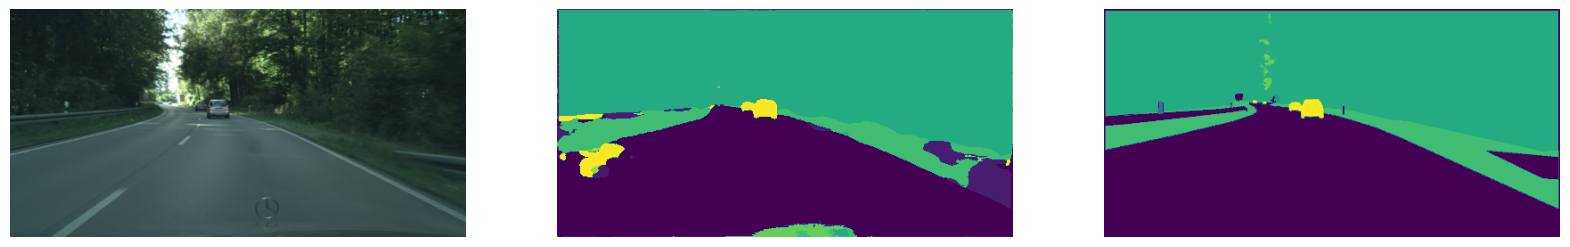

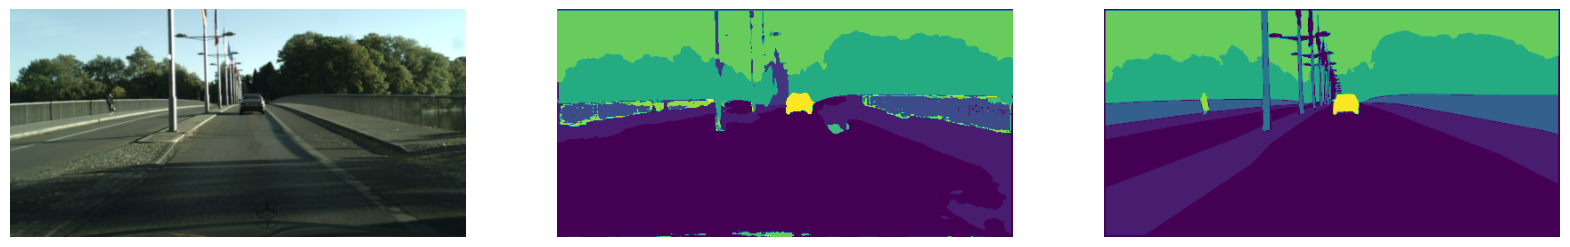

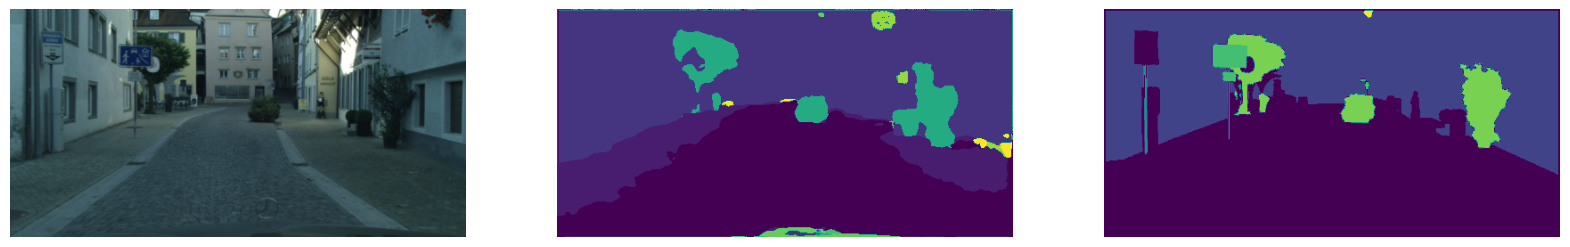

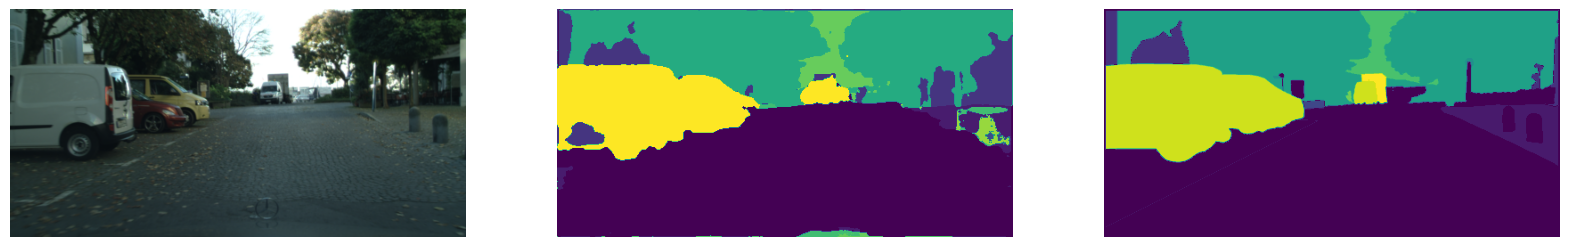

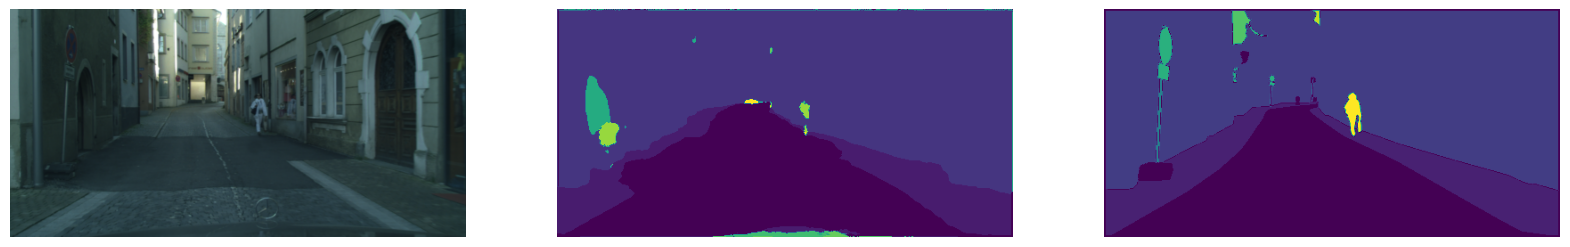

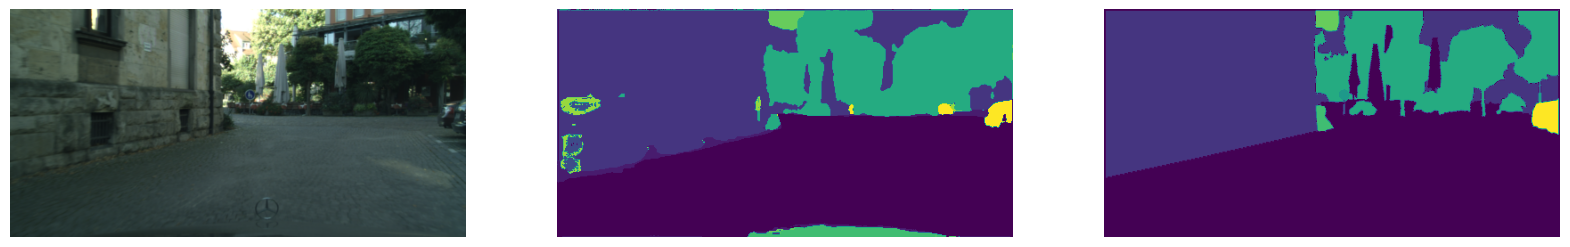

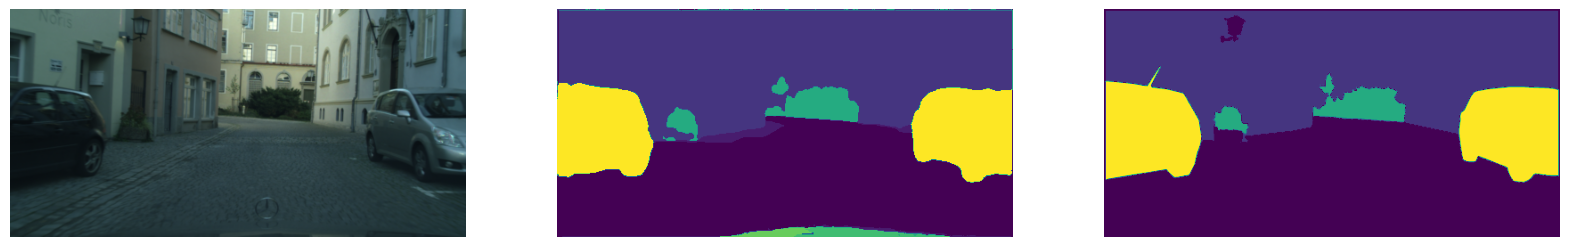

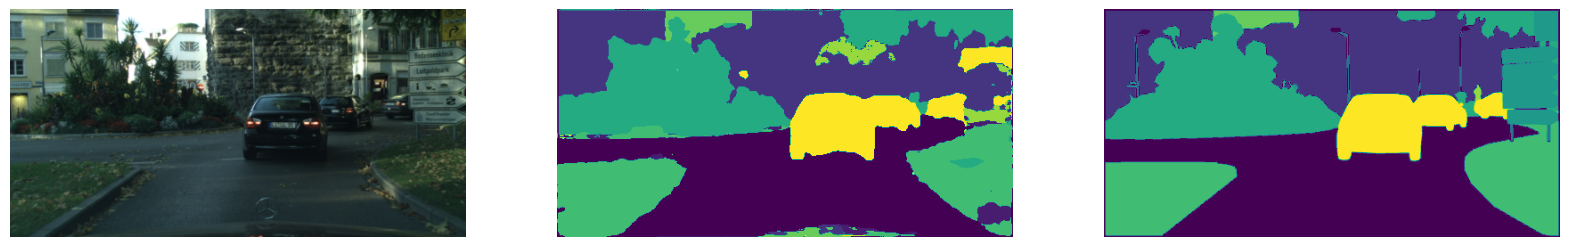

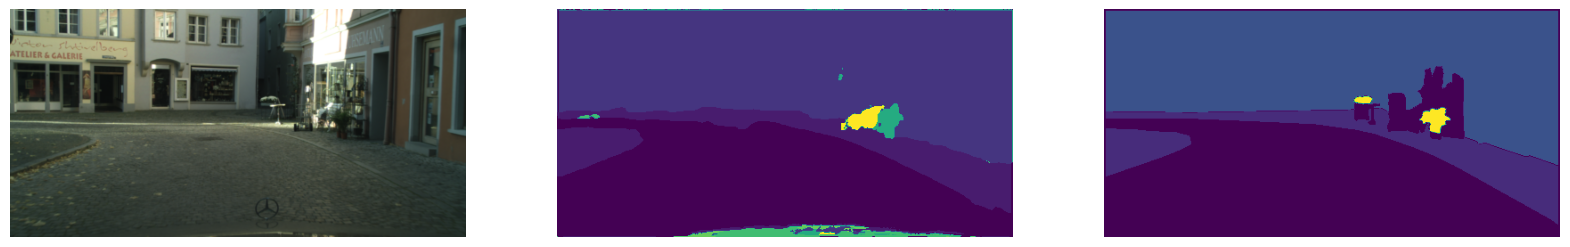

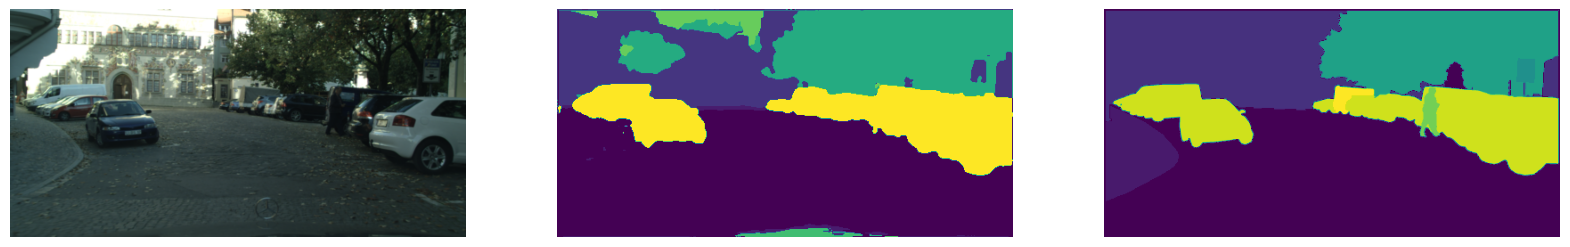

In [16]:
model.eval()

with torch.no_grad():
    for test_case_idx in range(10):
        valid_img, valid_mask = valid_ds[test_case_idx]
        valid_img = valid_img.unsqueeze(dim=0).to(device)

        gen_mask = model(valid_img)     
        # f, axarr = plt.subplots(1, total_num_class + 3, figsize = (20,15))
        f, axarr = plt.subplots(1, 3, figsize = (20,15))
        axarr[0].imshow(valid_img[0].cpu().permute(1, -1, 0).numpy())
        axarr[0].axis('off')
        axarr[1].imshow(torch.argmax(gen_mask[0], dim=0).cpu().unsqueeze(0).permute(1, -1, 0).numpy())
        axarr[1].axis('off')
        axarr[2].imshow(torch.argmax(valid_mask, dim=0).cpu().unsqueeze(0).permute(1, -1, 0).numpy())
        axarr[2].axis('off')
        # for idx in range(total_num_class):
        #     axarr[idx + 2].imshow(gen_mask[0][idx].unsqueeze(0).cpu().permute(1, -1, 0).numpy())
        #     axarr[idx + 2].axis('off')
        # axarr[total_num_class+2].imshow(torch.argmax(valid_mask, dim=0).unsqueeze(0).cpu().permute(1, -1, 0).numpy())
        # axarr[total_num_class+2].axis('off')